## MNIST手写数字训练集
+ 60000行的训练数据集（mnist.train）和10000行的测试数据集（mnist.test）

In [379]:
import torch

### 读取数据

In [380]:
import torchvision
import os
import struct
import numpy as np
from torch.utils import data
#打开文件
def load_data(path, kind='train'):
    #获取标签和数据位置
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte'% kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte'% kind)
    
    #打开标签文件
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)

    #打开图片文件
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

#打开训练文件
images_train_data,labels_train_data=load_data("data/MNIST/", kind='train')
#打开测试文件
images_test_data,labels_test_data=load_data("data/MNIST/", kind='t10k')
images_train_data[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

#### 显示部分数据

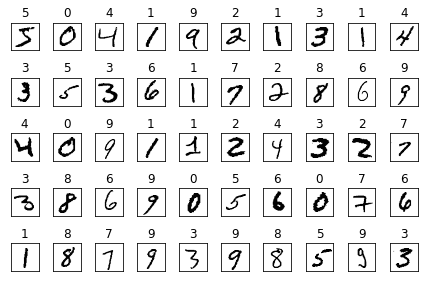

In [381]:
import matplotlib.pyplot as plt
#定义子图
fig, ax = plt.subplots(nrows=5,ncols=10,sharex=True,sharey=True)
#展平子图数组
ax = ax.flatten()
for i in range(50):
    #将数据转成像素矩阵
    img = images_train_data[i].reshape(28, 28)
    #显示子图
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    #显示子图标题
    ax[i].set_title(labels_train_data[i])
#不显示坐标轴
ax[0].set_xticks([])
ax[0].set_yticks([])
#显示子图
plt.tight_layout()
plt.show()

#### 规范化

In [382]:
#归一化图片
#训练集
images_train_data=torch.tensor(images_train_data/255)
#print(images_train_data[1])
#测试集
images_test_data=torch.tensor(images_test_data/255)
#print(images_test_data[1])
#标签转为独热编码
import torch.nn.functional as F
#训练集
labels_train_data=F.one_hot(torch.tensor(labels_train_data).to(torch.int64),num_classes=10).to(torch.float64)
#print(labels_train_data[1])
#测试集(这里不用转不然预测模型时还得转回来)
labels_test_data=F.one_hot(torch.tensor(labels_test_data).to(torch.int64),num_classes=10).to(torch.float64)
#print(labels_test_data[1])

#### 抽样

In [383]:
### 抽样数量
random_sampling_num=10
#随机抽样
def random_sampling(input_data,num,rand=True):
    getdata=data.TensorDataset(*input_data)
    return data.DataLoader(getdata,num,shuffle=rand)

### 训练数据抽样
train= random_sampling((images_train_data,labels_train_data),10)
test = random_sampling((images_test_data,labels_test_data),10)

#a,b=next(iter(train))
#print(len(a),len(b))

### 定义模型

In [384]:
#将矩阵展平输入，输出10个
from torch import nn
net=nn.Sequential(nn.Flatten().to(torch.float64),nn.Linear(28*28,10).to(torch.float64))
def init_weight(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
net.apply(init_weight)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

### 损失函数

In [385]:
loss=nn.CrossEntropyLoss(reduction="none")

### 梯度下降

In [386]:
### 学习率
lr=0.1
trainer=torch.optim.SGD(net.parameters(),lr=lr)

### 计算正确率

In [387]:
def rigth_rate(y_guess,y):
    if len(y_guess)>1 and len(y)>1:
        y_guess=y_guess.argmax(axis=1)
        cmp =y_guess.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

## 训练

#### 循环样本 训练一次的模型

In [388]:
def training_once_model(net, train_iter, loss, updater):
    #将model设置为训练模式
    if isinstance(net,torch.nn.Module):
        net.train()
    # 计算训练损失总和、训练准确度总和、样本数
    #创建累加器
    addtion=[0.0]*3
    for x,y in train_iter:
        #预测
        y_guess=net(x)
        #损失
        l=loss(y_guess,y)
        #使用内置优化器和损失
        #if isinstance(updater,torch.optim.Optimizer):
        updater.zero_grad()
        l.mean().backward()
        updater.step()
        #else:
        # 使⽤定制的优化器和损失函数
        #l.sum().backward()
        #updater(X.shape[0])
        addtion[0]+=float(l.sum())
        addtion[1]+=rigth_rate(y_guess,y)
        addtion[2]+=y.numel()
    #      训练损失总和/样本数   ; 训练准确度总和/样本数
    return addtion[0]/addtion[2],addtion[1]/addtion[2]

#### 训练输入
+    主观概率为Q的观察者在看到根据概率P⽣成的数据时的预期惊异
+    （i）最⼤化观测数据的似然；（ii）最⼩化传达标签所需的惊异

In [389]:
def training_input(net,train_iter,loss,learnmun,updatew):
    for learn in range(learnmun):
        train_once= training_once_model(net,train_iter,loss,updatew)
    #获得得分损失率和准确率
    train_loss, train_acc = train_once
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc


In [390]:
training_input(net=net,train_iter=train,loss=loss,learnmun=10,updatew=trainer)

AssertionError: 0.10065166666666667

## 预测

In [404]:
def predict(net,iter):
    for x,y in iter:
        break
    trues = y
    preds =net(x).argmax(axis=1)
    return x,preds,trues

In [405]:
x,preds,trues=predict(net,test)
print(preds)

tensor([4, 2, 8, 2, 1, 6, 6, 6, 0, 9])


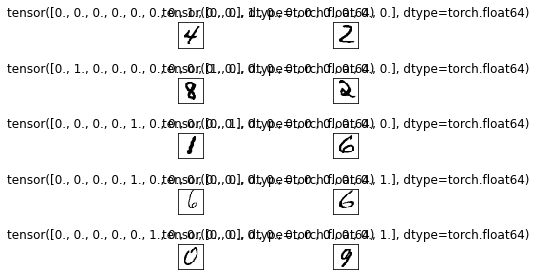

In [406]:
import matplotlib.pyplot as plt
#定义子图
fig, ax = plt.subplots(nrows=5,ncols=2,sharex=True,sharey=True)
#展平子图数组
ax = ax.flatten()
for i in range(10):
    #将数据转成像素矩阵
    img = x[i].reshape(28, 28)
    #显示子图
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    #显示子图标题
    ax[i].set_title(labels_test_data[i])
#不显示坐标轴
ax[0].set_xticks([])
ax[0].set_yticks([])
#显示子图
plt.tight_layout()
plt.show()